In [1]:
import tensorflow as tf

# Enable TensorFlow device placement logging
tf.debugging.set_log_device_placement(False)

# Check if GPU is available and set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  1


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd

from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import hamming_loss

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, TimeDistributed, Input, Attention, Conv1D
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop
import pynvml
import time

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score

New Classification
- 0=everything else
- 1=walking
- 2=descending stairs
- 3=ascending stairs


### Train Test Split

In [3]:
demograph = pd.read_csv('participant_demog.csv')
patient_ids = demograph['subj_id'].unique()
train_ids, test_ids = train_test_split(patient_ids, test_size=0.3, random_state=42)

# Split the data based on patient IDs
train_df =  demograph[demograph['subj_id'].isin(train_ids)]
test_df =  demograph[demograph['subj_id'].isin(test_ids)]

print("Train Patient IDs:", train_ids)
print("Test Patient IDs:", test_ids)

Train Patient IDs: ['id8af5374b' 'id3e3e50c7' 'id650857ca' 'id86237981' 'id34e056c8'
 'id7c20ee7a' 'id5993bf4a' 'idd80ac2b4' 'id5308a7d6' 'id82b9735c'
 'id079c763c' 'ida61e8ddf' 'idbae5a811' 'idecc9265e' 'idb221f542'
 'id1f372081' 'id4ea159a8' 'id8e66893c' 'idf5e3678b' 'id9603e9c3'
 'id687ab496' 'idff99de96']
Test Patient IDs: ['idfc5f05e4' 'id37a54bbf' 'id00b70b13' 'idf1ce9a0f' 'idc91a49d0'
 'id1c7e64ad' 'idf540d82b' 'id1165e00c' 'idc735fc09' 'idabd0c53c']


In [4]:
def sliding_windows(data, window_size, step_size):
    window_list = []
    for start in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[start:start + window_size]  # Extract the window
        first_value = window.iloc[0].copy()  # Take the first value of the window
        window_list.append(first_value)
    return window_list

In [5]:
def load_features(id_df, featured=True, window_size=128, step_size=128):
    X = []
    y = []
    
    for index, row in id_df.iterrows():
        id = row['subj_id']
        print(f'Processing patient {id}')
        output_dir = 'featured' if featured else 'filtered'
        pp = pd.read_csv(f'{output_dir}/{id}.csv')
        
        if not featured:
            norm_columns = [col for col in pp.columns if col.endswith('_norm')]
            pp = pp[norm_columns + ['activity']]
            pp['activity'] = pp['activity'].apply(lambda x: x if x in [1, 2, 3] else 0)
            
            # Apply sliding window
            windows = sliding_windows(pp, window_size, step_size)
            pp_X = np.array([window.drop('activity') for window in windows], dtype=np.float32)
            pp_y = np.array([window['activity'] for window in windows], dtype=np.int32)
            X.append(pp_X)
            y.append(pp_y)
            
        else:
            pp_X = pp.drop(columns=['activity']).values.astype(np.float32)  # Convert to 32-bit floats
            pp_y = pp['activity'].values.astype(np.int32)  # Convert to 32-bit integers if needed
            X.append(pp_X)
            y.append(pp_y)
    
    return np.array(X), np.array(y)

In [6]:
featured = False
X_train0, y_train0 = load_features(train_df, featured=featured)
X_test0, y_test0 = load_features(test_df, featured=featured)

Processing patient id5993bf4a
Processing patient idd80ac2b4
Processing patient id82b9735c
Processing patient id8af5374b
Processing patient id650857ca
Processing patient idff99de96
Processing patient id4ea159a8
Processing patient id8e66893c
Processing patient id34e056c8
Processing patient id86237981
Processing patient idf5e3678b
Processing patient id3e3e50c7
Processing patient idecc9265e
Processing patient id687ab496
Processing patient id1f372081
Processing patient id079c763c
Processing patient idbae5a811
Processing patient id7c20ee7a
Processing patient id5308a7d6
Processing patient ida61e8ddf
Processing patient id9603e9c3
Processing patient idb221f542
Processing patient idabd0c53c
Processing patient idc91a49d0
Processing patient id1c7e64ad
Processing patient idc735fc09
Processing patient id37a54bbf
Processing patient idf1ce9a0f
Processing patient id00b70b13
Processing patient id1165e00c
Processing patient idfc5f05e4
Processing patient idf540d82b


In [7]:
# Concatenate data of all patients
X_train_long = np.concatenate(X_train0, axis=0)
y_train_long = np.concatenate(y_train0, axis=0)

X_test_long = np.concatenate(X_test0, axis=0)
y_test_long = np.concatenate(y_test0, axis=0)

print(f'X_train_long shape: {X_train_long.shape}')
print(f'y_train_long shape: {y_train_long.shape}')

X_train_long shape: (16170, 4)
y_train_long shape: (16170,)


In [8]:
# Normalize train and test separately to avoid leaking
scaler = StandardScaler()

X_train_long_scaled = scaler.fit_transform(X_train_long)
X_test_long_scaled = scaler.transform(X_test_long)

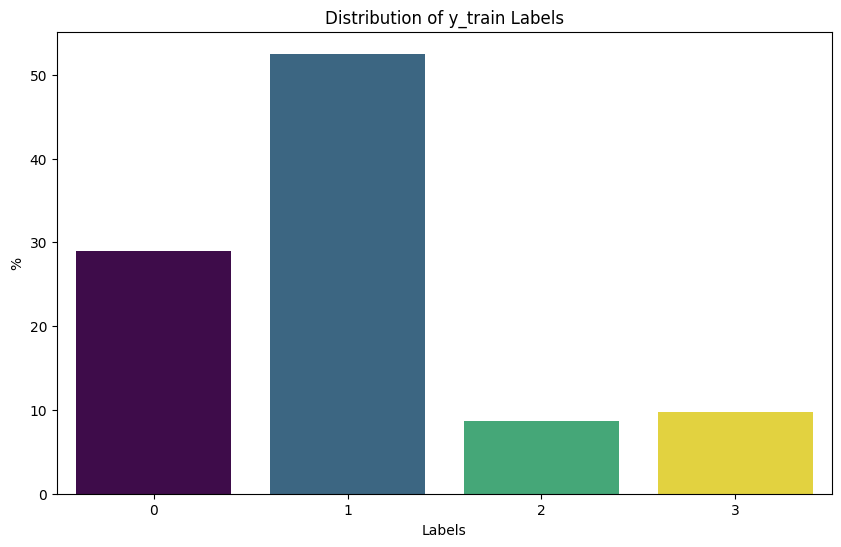

In [9]:
label_counts = pd.Series(y_train_long).value_counts().sort_index()

# %
total = label_counts.sum()
label_percentages = (label_counts / total) * 100

label_counts_df = label_percentages.reset_index()
label_counts_df.columns = ['Labels', 'Percentage']

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Labels', y='Percentage', hue='Labels', data=label_counts_df, palette='viridis', dodge=False)
plt.title('Distribution of y_train Labels')
plt.xlabel('Labels')
plt.ylabel('%')
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

In [10]:
timesteps = X_train0.shape[1]  
# Ensure the total number of data points is divisible by timesteps
num_train_samples = X_train_long_scaled.shape[0] // timesteps
num_test_samples = X_test_long_scaled.shape[0] // timesteps

X_train = X_train_long_scaled[:num_train_samples * timesteps].reshape((num_train_samples, timesteps, -1))
y_train = y_train_long[:num_train_samples * timesteps].reshape((num_train_samples, timesteps, 1))

X_test = X_test_long_scaled[:num_test_samples * timesteps].reshape((num_test_samples, timesteps, -1))
y_test = y_test_long[:num_test_samples * timesteps].reshape((num_test_samples, timesteps, 1))

print(f'X_train: {X_train.shape}') 
print(f'y_train: {y_train.shape}')  
print(f'X_test: {X_test.shape}')  
print(f'y_test: {y_test.shape}')  

X_train: (22, 735, 4)
y_train: (22, 735, 1)
X_test: (10, 735, 4)
y_test: (10, 735, 1)


### Train Val Split

In [11]:
split_index = int(0.3 * len(X_train))

In [12]:
indices = np.arange(len(X_train))
np.random.seed(898)
np.random.shuffle(indices)
print(indices)

[ 5 12  3 18  1 19 11  9  8 14  2  0  6 21  4 15 16 13 17 20 10  7]


In [13]:
train_indices = indices[split_index:]
val_indices = indices[:split_index]

In [14]:
X_train_split = X_train[train_indices]
y_train_split = y_train[train_indices]
X_val_split = X_train[val_indices]
y_val_split = y_train[val_indices]
print("X_train_split shape:", X_train_split.shape) 
print("y_train_split shape:", y_train_split.shape) 
print("X_val_split shape:", X_val_split.shape)      
print("y_val_split shape:", y_val_split.shape)  

X_train_split shape: (16, 735, 4)
y_train_split shape: (16, 735, 1)
X_val_split shape: (6, 735, 4)
y_val_split shape: (6, 735, 1)


## RNN ONLY

In [15]:
# # only RNN
def solo_rnn(units=50, dropout_rate=0.2, recurrent_dropout_rate=0.2):
    model = Sequential([
        SimpleRNN(units, activation='tanh', input_shape=(X_train_split.shape[1], X_train_split.shape[2]), return_sequences=True, 
                  dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate),
        SimpleRNN(units, activation='tanh', return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate),
        Dense(4, activation='softmax')  # softmax for classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
def grid_search(param_grid, model_fn, conv=False):
    results = []

    for units in param_grid['units']:
        for dropout_rate in param_grid['dropout_rate']:
            for recurrent_dropout_rate in param_grid['recurrent_dropout_rate']:
                for epochs in param_grid['epochs']:
                    for batch_size in param_grid['batch_size']:
                        if conv:
                            for conv_filters in param_grid['conv_filters']:
                                for kernel_size in param_grid['kernel_size']:
                                    print(f"Training with units={units}, dropout_rate={dropout_rate}, recurrent_dropout_rate={recurrent_dropout_rate}, epochs={epochs}, batch_size={batch_size}, conv_filters={conv_filters}, kernel_size={kernel_size}")
                                    
                                    # Create and train the model using the provided model function
                                    model = model_fn(units, conv_filters, kernel_size, dropout_rate, recurrent_dropout_rate)
                                    model.fit(X_train_split, y_train_split, epochs=epochs, batch_size=batch_size, validation_data=(X_val_split, y_val_split), verbose=0)
                                    val_loss, val_accuracy = model.evaluate(X_val_split, y_val_split, verbose=0)
                                    
                                    print(f"Validation accuracy: {val_accuracy}")
                                    
                                    results.append({
                                        'units': units,
                                        'dropout_rate': dropout_rate,
                                        'recurrent_dropout_rate': recurrent_dropout_rate,
                                        'epochs': epochs,
                                        'batch_size': batch_size,
                                        'conv_filters': conv_filters,
                                        'kernel_size': kernel_size,
                                        'val_accuracy': val_accuracy
                                    })
                        else:
                            print(f"Training with units={units}, dropout_rate={dropout_rate}, recurrent_dropout_rate={recurrent_dropout_rate}, epochs={epochs}, batch_size={batch_size}")

                            # Create and train the model using the provided model function
                            model = model_fn(units, dropout_rate, recurrent_dropout_rate)
                            model.fit(X_train_split, y_train_split, epochs=epochs, batch_size=batch_size, validation_data=(X_val_split, y_val_split), verbose=0)
                            val_loss, val_accuracy = model.evaluate(X_val_split, y_val_split, verbose=0)

                            print(f"Validation accuracy: {val_accuracy}")

                            results.append({
                                'units': units,
                                'dropout_rate': dropout_rate,
                                'recurrent_dropout_rate': recurrent_dropout_rate,
                                'epochs': epochs,
                                'batch_size': batch_size,
                                'val_accuracy': val_accuracy
                            })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='val_accuracy', ascending=False)
    return results_df

In [17]:
param_grid = {
    'units': [25, 50],
    'dropout_rate': [0, 0.1],
    'recurrent_dropout_rate': [0, 0.1],
    'epochs': [20],
    'batch_size': [8,32] 
}
res = grid_search(param_grid, solo_rnn)
best_params_rnn = res.iloc[0]

Training with units=25, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=8
Validation accuracy: 0.7918367385864258
Training with units=25, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=32
Validation accuracy: 0.5700680017471313
Training with units=25, dropout_rate=0, recurrent_dropout_rate=0.1, epochs=20, batch_size=8
Validation accuracy: 0.7714285850524902
Training with units=25, dropout_rate=0, recurrent_dropout_rate=0.1, epochs=20, batch_size=32
Validation accuracy: 0.43401360511779785
Training with units=25, dropout_rate=0.1, recurrent_dropout_rate=0, epochs=20, batch_size=8
Validation accuracy: 0.7673469185829163
Training with units=25, dropout_rate=0.1, recurrent_dropout_rate=0, epochs=20, batch_size=32
Validation accuracy: 0.5088435411453247
Training with units=25, dropout_rate=0.1, recurrent_dropout_rate=0.1, epochs=20, batch_size=8
Validation accuracy: 0.7673469185829163
Training with units=25, dropout_rate=0.1, recurrent_dropout_rate=0.1, epoc

In [18]:
res.head(5)

,units,dropout_rate,recurrent_dropout_rate,epochs,batch_size,val_accuracy
8,50,0.0,0.0,20,8,0.869388
12,50,0.1,0.0,20,8,0.844898
10,50,0.0,0.1,20,8,0.838095
14,50,0.1,0.1,20,8,0.829932
9,50,0.0,0.0,20,32,0.813605


In [ ]:
res.to_csv('res.csv')

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

start_time = time.time()
# Retrain best params with longer epochs 
brnn = solo_rnn(
    units=int(best_params_rnn['units']),
    dropout_rate=float(best_params_rnn['dropout_rate']),
    recurrent_dropout_rate=float(best_params_rnn['recurrent_dropout_rate'])
)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)


history_rnn = brnn.fit(
    X_train_split,
    y_train_split, 
    epochs=60, 
    batch_size=int(best_params_rnn['batch_size']), 
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr]
)

end_time = time.time()
execution_time = end_time - start_time

Epoch 1/60
2/2 [==============================] - 2s 963ms/step - loss: 1.5176 - accuracy: 0.2075 - val_loss: 1.4291 - val_accuracy: 0.2667 - lr: 0.0010
Epoch 2/60
2/2 [==============================] - 2s 843ms/step - loss: 1.4025 - accuracy: 0.2830 - val_loss: 1.3246 - val_accuracy: 0.3510 - lr: 0.0010
Epoch 3/60
2/2 [==============================] - 2s 777ms/step - loss: 1.2986 - accuracy: 0.3735 - val_loss: 1.2175 - val_accuracy: 0.4395 - lr: 0.0010
Epoch 4/60
2/2 [==============================] - 2s 1s/step - loss: 1.1883 - accuracy: 0.4646 - val_loss: 1.1006 - val_accuracy: 0.5293 - lr: 0.0010
Epoch 5/60
2/2 [==============================] - 1s 773ms/step - loss: 1.0738 - accuracy: 0.5422 - val_loss: 1.0028 - val_accuracy: 0.5701 - lr: 0.0010
Epoch 6/60
2/2 [==============================] - 2s 1s/step - loss: 0.9845 - accuracy: 0.5721 - val_loss: 0.9334 - val_accuracy: 0.5918 - lr: 0.0010
Epoch 7/60
2/2 [==============================] - 2s 731ms/step - loss: 0.9172 - accurac

In [20]:
print(f"Execution Time: {execution_time} seconds")

Execution Time: 117.93806266784668 seconds


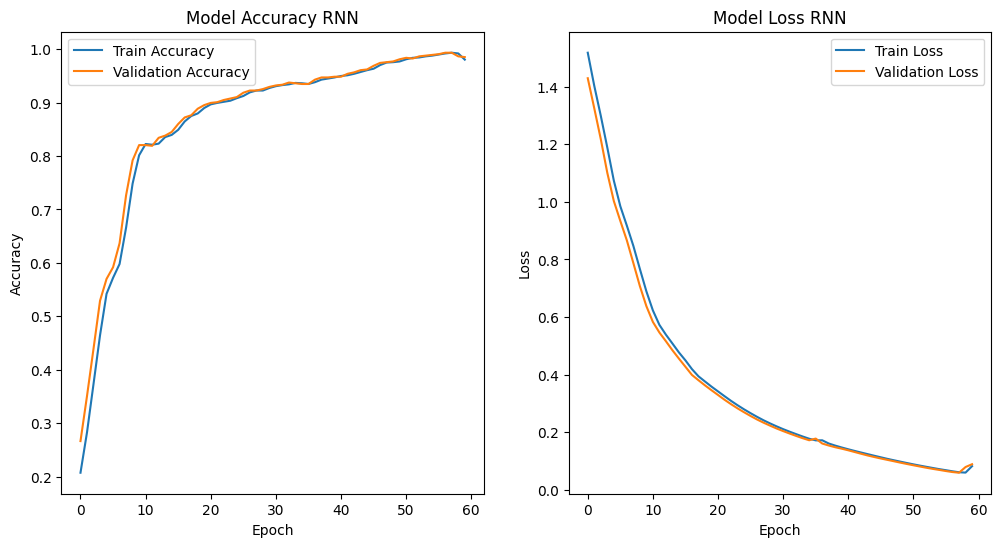

In [21]:
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy RNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 327ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2130
           1       1.00      0.98      0.99      3860
           2       0.98      0.95      0.97       640
           3       0.90      1.00      0.95       720

    accuracy                           0.99      7350
   macro avg       0.97      0.98      0.98      7350
weighted avg       0.99      0.99      0.99      7350



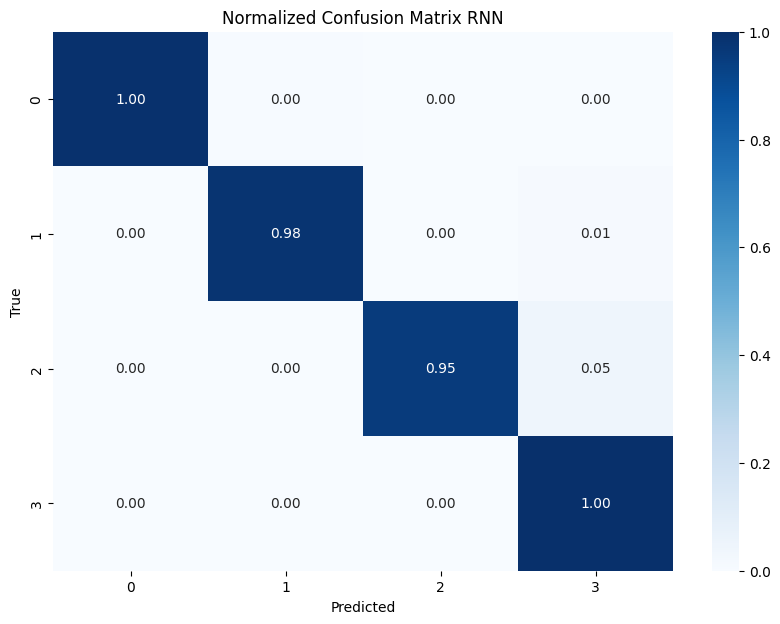

In [22]:
# Make predictions
y_pred1 = brnn.predict(X_test)
y_pred_classes1 = np.argmax(y_pred1, axis=-1)

# Flatten the predictions and true labels
y_pred_flat1 = y_pred_classes1.flatten()
y_true_flat1 = y_test.flatten()

# Generate the classification report
report1 = classification_report(y_true_flat1, y_pred_flat1, zero_division=0, output_dict=True)
print(classification_report(y_true_flat1, y_pred_flat1, zero_division=0))

# Calculate confusion matrix
cm = confusion_matrix(y_true_flat1, y_pred_flat1)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix RNN')
plt.show()

## CRNN

In [23]:
def CRNN_model(units=50, conv_filters=32, kernel_size=3, dropout_rate=0.2, recurrent_dropout_rate=0.2):
    model = Sequential([
        Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same', 
               input_shape=(X_train_split.shape[1], X_train_split.shape[2])),
        
        SimpleRNN(units, activation='tanh', return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate),
        SimpleRNN(units, activation='tanh', return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate),
        Dense(4, activation='softmax')  # softmax for classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [24]:
param_grid = {
    'units': [50],
    'dropout_rate': [0, 0.1],
    'recurrent_dropout_rate': [0, 0.1],
    'epochs': [20],
    'batch_size': [8, 32],
    'conv_filters': [16, 32],  
    'kernel_size': [3, 5]      
}

res2 = grid_search(param_grid, CRNN_model, conv=True)
best_params_crnn = res2.iloc[0]

Training with units=50, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=8, conv_filters=16, kernel_size=3
Validation accuracy: 0.8938775658607483
Training with units=50, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=8, conv_filters=16, kernel_size=5
Validation accuracy: 0.8081632852554321
Training with units=50, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=8, conv_filters=32, kernel_size=3
Validation accuracy: 0.9442176818847656
Training with units=50, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=8, conv_filters=32, kernel_size=5
Validation accuracy: 0.9047619104385376
Training with units=50, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=32, conv_filters=16, kernel_size=3
Validation accuracy: 0.8095238208770752
Training with units=50, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=32, conv_filters=16, kernel_size=5
Validation accuracy: 0.7891156673431396
Training with units=50, dr

In [25]:
res2.head(5)

,units,dropout_rate,recurrent_dropout_rate,epochs,batch_size,conv_filters,kernel_size,val_accuracy
2,50,0.0,0.0,20,8,32,3,0.944218
18,50,0.1,0.0,20,8,32,3,0.910204
3,50,0.0,0.0,20,8,32,5,0.904762
0,50,0.0,0.0,20,8,16,3,0.893878
25,50,0.1,0.1,20,8,16,5,0.884354


In [26]:
start_time = time.time()

# Retrain best params with longer epochs 
crnn = CRNN_model(
    units=int(best_params_crnn['units']),
    conv_filters=int(best_params_crnn['conv_filters']),
    kernel_size=int(best_params_crnn['kernel_size']),
    dropout_rate=float(best_params_crnn['dropout_rate']),
    recurrent_dropout_rate=float(best_params_crnn['recurrent_dropout_rate'])
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

history_crnn = crnn.fit(
    X_train_split,
    y_train_split,
    epochs=60,
    batch_size=int(best_params_crnn['batch_size']),
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr]
)

end_time = time.time()
execution_time = end_time - start_time

Epoch 1/60
2/2 [==============================] - 4s 2s/step - loss: 1.4762 - accuracy: 0.2497 - val_loss: 1.2426 - val_accuracy: 0.4313 - lr: 0.0010
Epoch 2/60
2/2 [==============================] - 2s 887ms/step - loss: 1.1960 - accuracy: 0.4680 - val_loss: 1.0816 - val_accuracy: 0.5605 - lr: 0.0010
Epoch 3/60
2/2 [==============================] - 2s 1s/step - loss: 1.0582 - accuracy: 0.5871 - val_loss: 1.0036 - val_accuracy: 0.6653 - lr: 0.0010
Epoch 4/60
2/2 [==============================] - 3s 2s/step - loss: 0.9908 - accuracy: 0.6646 - val_loss: 0.9485 - val_accuracy: 0.6707 - lr: 0.0010
Epoch 5/60
2/2 [==============================] - 2s 903ms/step - loss: 0.9300 - accuracy: 0.6810 - val_loss: 0.8674 - val_accuracy: 0.7061 - lr: 0.0010
Epoch 6/60
2/2 [==============================] - 2s 1s/step - loss: 0.8431 - accuracy: 0.7163 - val_loss: 0.7683 - val_accuracy: 0.7388 - lr: 0.0010
Epoch 7/60
2/2 [==============================] - 2s 953ms/step - loss: 0.7431 - accuracy: 0.7

In [27]:
print(f"Execution Time: {execution_time} seconds")

Execution Time: 152.52374815940857 seconds


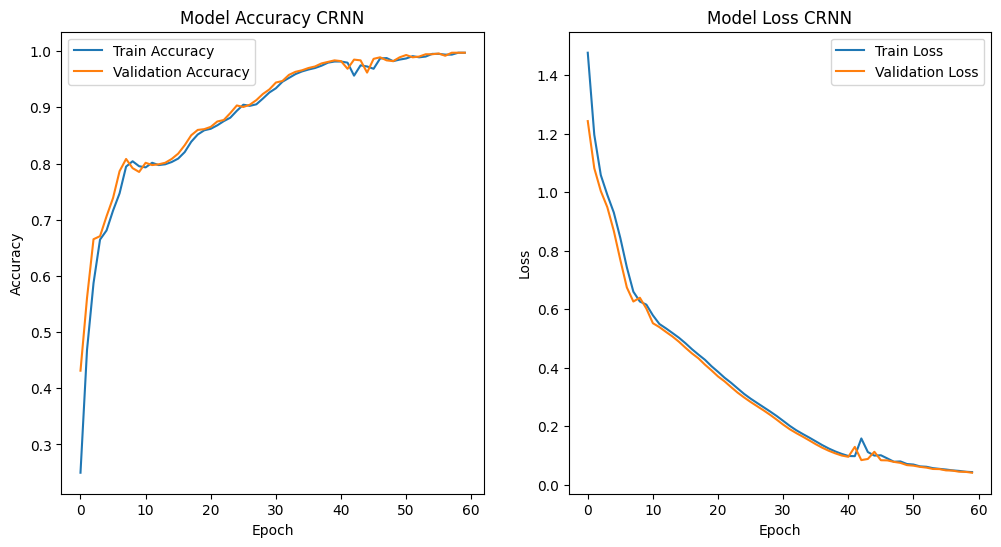

In [28]:
# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_crnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_crnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy CRNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_crnn.history['loss'], label='Train Loss')
plt.plot(history_crnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss CRNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 309ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2130
           1       0.99      1.00      1.00      3860
           2       1.00      1.00      1.00       640
           3       1.00      0.99      0.99       720

    accuracy                           1.00      7350
   macro avg       1.00      1.00      1.00      7350
weighted avg       1.00      1.00      1.00      7350



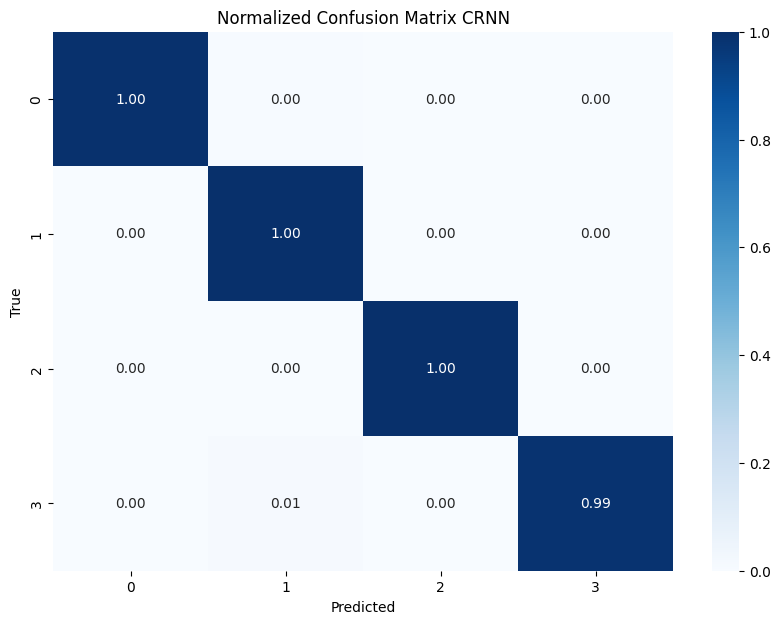

In [29]:
y_pred_crnn = crnn.predict(X_test)
y_pred_classes_crnn = np.argmax(y_pred_crnn, axis=-1)


y_pred_flat_crnn = y_pred_classes_crnn.flatten()
y_true_flat_crnn = y_test.flatten()

report_crnn = classification_report(y_true_flat_crnn, y_pred_flat_crnn, zero_division=0, output_dict=True)
print(classification_report(y_true_flat_crnn, y_pred_flat_crnn, zero_division=0))

cm_crnn = confusion_matrix(y_true_flat_crnn, y_pred_flat_crnn)
cm_normalized_crnn = cm_crnn.astype('float') / cm_crnn.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized_crnn, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix CRNN')
plt.show()

## Bidirectional RNN

In [30]:
from tensorflow.keras.layers import Bidirectional

def CBR(units=40, conv_filters=32, kernel_size=3, dropout_rate=0, recurrent_dropout_rate=0):
    model = Sequential([
        Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same',
               input_shape=(X_train_split.shape[1], X_train_split.shape[2])),
        # Bidirectional RNN layer 
        Bidirectional(SimpleRNN(units, activation='tanh', return_sequences=True, 
                                dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)),
        Dense(4, activation='softmax')
    ])
    
    # Compiling the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [32]:
param_grid = {
    'units': [40],
    'dropout_rate': [0, 0.1],
    'recurrent_dropout_rate': [0, 0.1],
    'epochs': [20],
    'batch_size': [8, 32],
    'conv_filters': [16, 32],  
    'kernel_size': [3, 5]      
}

res3 = grid_search(param_grid, CBR, conv=True)
best_params_cbr = res3.iloc[0]

Training with units=40, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=8, conv_filters=16, kernel_size=3
Validation accuracy: 0.8081632852554321
Training with units=40, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=8, conv_filters=16, kernel_size=5
Validation accuracy: 0.8312925100326538
Training with units=40, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=8, conv_filters=32, kernel_size=3
Validation accuracy: 0.8231292366981506
Training with units=40, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=8, conv_filters=32, kernel_size=5
Validation accuracy: 0.8707482814788818
Training with units=40, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=32, conv_filters=16, kernel_size=3
Validation accuracy: 0.7972789406776428
Training with units=40, dropout_rate=0, recurrent_dropout_rate=0, epochs=20, batch_size=32, conv_filters=16, kernel_size=5
Validation accuracy: 0.7945578098297119
Training with units=40, dr

In [33]:
res3.head(5)

,units,dropout_rate,recurrent_dropout_rate,epochs,batch_size,conv_filters,kernel_size,val_accuracy
11,40,0.0,0.1,20,8,32,5,0.874830
3,40,0.0,0.0,20,8,32,5,0.870748
27,40,0.1,0.1,20,8,32,5,0.863946
9,40,0.0,0.1,20,8,16,5,0.857143
26,40,0.1,0.1,20,8,32,3,0.843537


In [34]:
start_time = time.time()

# Retrain best params with longer epochs 
cbr_done = CBR(
    units=int(best_params_crnn['units']),
    conv_filters=int(best_params_crnn['conv_filters']),
    kernel_size=int(best_params_crnn['kernel_size']),
    dropout_rate=float(best_params_crnn['dropout_rate']),
    recurrent_dropout_rate=float(best_params_crnn['recurrent_dropout_rate'])
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

history_cbr = cbr_done.fit(
    X_train_split,
    y_train_split,
    epochs=60,
    batch_size=int(best_params_crnn['batch_size']),
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr]
)

end_time = time.time()
execution_time = end_time - start_time

Epoch 1/60
2/2 [==============================] - 4s 2s/step - loss: 1.2687 - accuracy: 0.4136 - val_loss: 1.1294 - val_accuracy: 0.5646 - lr: 0.0010
Epoch 2/60
2/2 [==============================] - 2s 950ms/step - loss: 1.0984 - accuracy: 0.5823 - val_loss: 1.0257 - val_accuracy: 0.6245 - lr: 0.0010
Epoch 3/60
2/2 [==============================] - 2s 867ms/step - loss: 1.0109 - accuracy: 0.6327 - val_loss: 0.9689 - val_accuracy: 0.6639 - lr: 0.0010
Epoch 4/60
2/2 [==============================] - 2s 1s/step - loss: 0.9540 - accuracy: 0.6728 - val_loss: 0.9076 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 5/60
2/2 [==============================] - 2s 861ms/step - loss: 0.8923 - accuracy: 0.7136 - val_loss: 0.8489 - val_accuracy: 0.7592 - lr: 0.0010
Epoch 6/60
2/2 [==============================] - 2s 950ms/step - loss: 0.8356 - accuracy: 0.7653 - val_loss: 0.7956 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 7/60
2/2 [==============================] - 2s 963ms/step - loss: 0.7815 - accurac

In [35]:
print(f"Execution Time: {execution_time} seconds")

Execution Time: 123.07342791557312 seconds


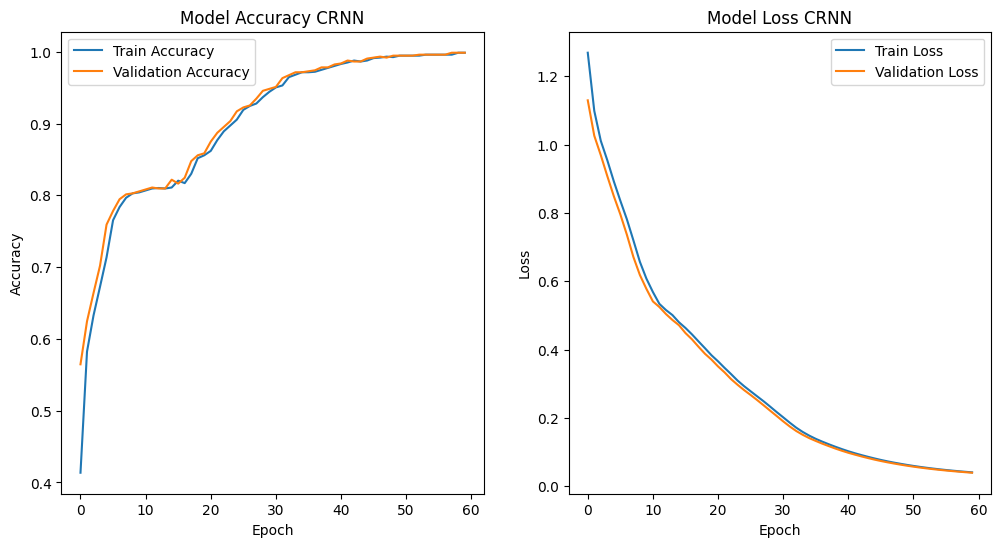

In [36]:
# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_cbr.history['accuracy'], label='Train Accuracy')
plt.plot(history_cbr.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy CRNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_cbr.history['loss'], label='Train Loss')
plt.plot(history_cbr.history['val_loss'], label='Validation Loss')
plt.title('Model Loss CRNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 309ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2130
           1       1.00      1.00      1.00      3860
           2       1.00      1.00      1.00       640
           3       1.00      0.99      0.99       720

    accuracy                           1.00      7350
   macro avg       1.00      1.00      1.00      7350
weighted avg       1.00      1.00      1.00      7350



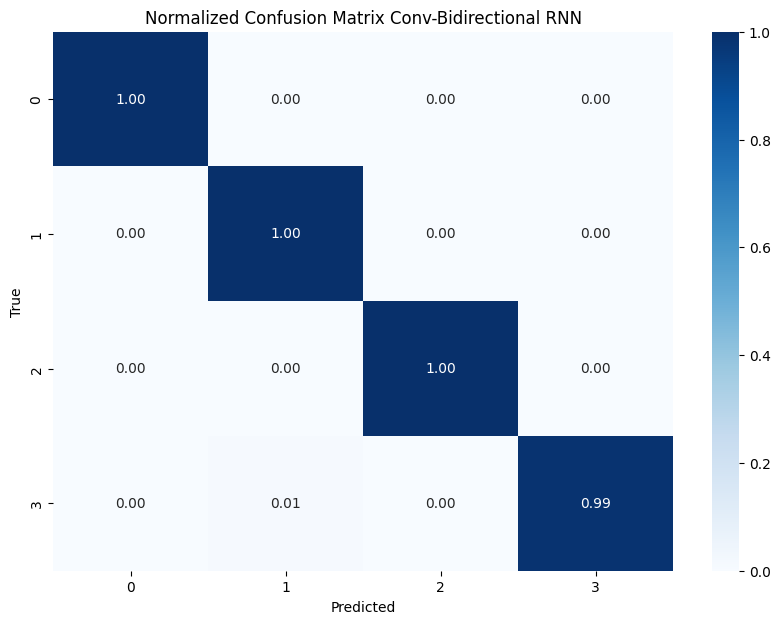

In [37]:
y_pred_cbr = cbr_done.predict(X_test)
y_pred_classes_cbr = np.argmax(y_pred_cbr, axis=-1)


y_pred_flat_cbr = y_pred_classes_cbr.flatten()
y_true_flat_cbr = y_test.flatten()

report_cbr = classification_report(y_true_flat_cbr, y_pred_flat_cbr, zero_division=0, output_dict=True)
print(classification_report(y_true_flat_cbr, y_pred_flat_cbr, zero_division=0))

cm_cbr = confusion_matrix(y_true_flat_cbr, y_pred_flat_cbr)
cm_normalized_cbr = cm_cbr.astype('float') / cm_cbr.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized_cbr, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix Conv-Bidirectional RNN')
plt.show()